In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [6]:
base_dir = os.getcwd()
train_path = os.path.join(base_dir, "../data/train_data.csv")
test_path = os.path.join(base_dir, "../data/test_data_clean.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)



In [7]:
train_df["label"] = (train_df["label"] > 0.4).astype(int)
test_df["isHate"] = (test_df["isHate"] > 0.4).astype(int)

train_texts = train_df["text"].astype(str).tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["comment"].astype(str).tolist()
test_labels = test_df["isHate"].tolist()

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(texts):
    return tokenizer(texts, truncation=True, padding='max_length', max_length=128, return_tensors="pt")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        encodings = tokenize(texts)
        self.input_ids = encodings['input_ids']
        self.attn_mask = encodings['attention_mask']
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_mask[idx],
            'label': self.labels[idx]
        }



In [9]:
train_dataset = TextDataset(train_texts, train_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = nn.Embedding(30522, 768)  
        self.classifier = nn.Sequential(
            nn.Linear(128 * 768, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids):
        x = self.bert(input_ids)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


In [11]:
for epoch in range(3):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)

        outputs = model(input_ids).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} Loss: {loss.item():.4f}")

Epoch 1 Loss: 0.6610
Epoch 2 Loss: 0.5951
Epoch 3 Loss: 0.7544


In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids).squeeze()
        preds = (outputs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds))

Accuracy: 0.44789579158316634
F1 Score: 0.6061472480343102
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.04      0.08       565
           1       0.44      0.98      0.61       433

    accuracy                           0.45       998
   macro avg       0.58      0.51      0.34       998
weighted avg       0.60      0.45      0.31       998



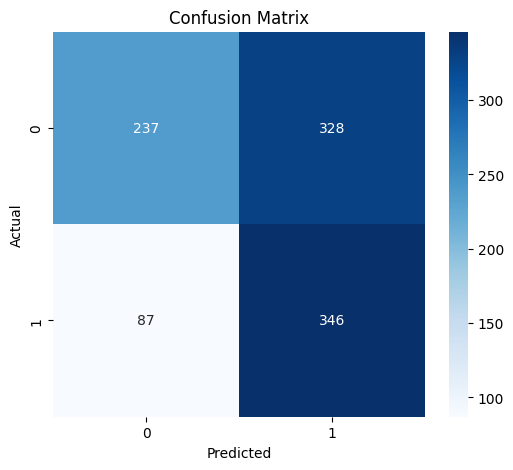

In [22]:
probs_class1 = probs[:, 1]

custom_preds = (probs_class1 > 0.4).astype(int)

y_true = np.array(test_labels).ravel()
y_pred = custom_preds.ravel()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


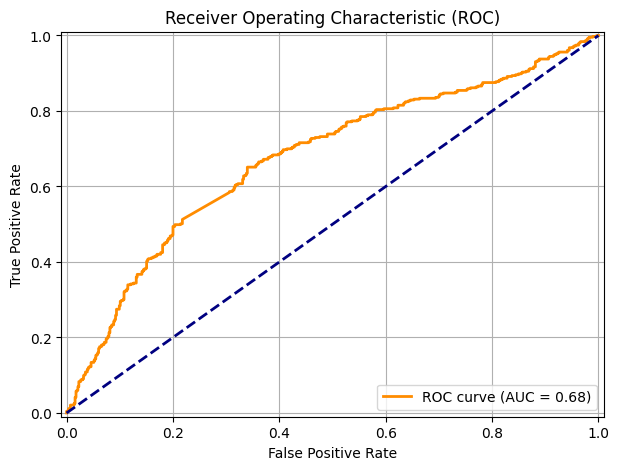

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probs_class1 = probs[:, 1]

y_true = np.array(test_labels).ravel()

fpr, tpr, thresholds = roc_curve(y_true, probs_class1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
